# info

1. 데이터 셋 info
- images 폴더 안에는 '1,000 개의 이미지 파일 * 101Categories' = 101,000 개의 이미지 파일이 들어있음
- 모든 파일을 학습시키려면 시간이 너무 오래걸림 (ex. 참고한 사이트를 보니 학습하는데만 대략 37시간 걸림;)
- 따라서 우리는 전체 데이터에서 1/10만을 Sampling 하여 학습함 ( 100 imagefiles * 101 Categories )

### Import: 필요한 패키지, 모듈 임포트

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report

### Creating File DataFrame: 이미지 파일 데이터 프레임 생성

In [ ]:
# 이미지 파일 경로 설정1
image_dir = Path('./food102/images')

In [13]:
# 이미지 파일 경로 설정 및 매핑
filepaths = list(image_dir.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

# 데이터프레임: 판다스 객체(시리즈)로 연결
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')
images = pd.concat([filepaths, labels], axis=1)

# 카테고리 당 100개의 랜덤 이미지를 샘플링하여 'image_df' 객체로 연결
category_samples = []
for category in images['Label'].unique():
    category_slice = images.query("Label == @category")
    category_samples.append(category_slice.sample(100, random_state=1))
image_df = pd.concat(category_samples, axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)

food102\images\apple_pie\1005649.jpg


In [4]:
# 샘플링 결과 확인1
image_df

,Filepath,Label
0,food102\images\paella\1769909.jpg,paella
1,food102\images\steak\2815172.jpg,steak
2,food102\images\bread_pudding\272991.jpg,bread_pudding
3,food102\images\waffles\1854304.jpg,waffles
4,food102\images\french_toast\3009499.jpg,french_toast
...,...,...
10095,food102\images\croque_madame\3389786.jpg,croque_madame
10096,food102\images\poutine\227190.jpg,poutine
10097,food102\images\breakfast_burrito\790446.jpg,breakfast_burrito
10098,food102\images\guacamole\2979136.jpg,guacamole


In [5]:
# 샘플링 결과 확인2
image_df['Label'].value_counts()

paella                  100
red_velvet_cake         100
baby_back_ribs          100
shrimp_and_grits        100
cup_cakes               100
                       ... 
takoyaki                100
pad_thai                100
fried_rice              100
strawberry_shortcake    100
apple_pie               100
Name: Label, Length: 101, dtype: int64

### Train-Test Split: 학습데이터와 테스트데이터 분리

In [6]:
# sklearn을 이용하여 데이터를 랜덤하게 7:3으로 분리
train_df, test_df = train_test_split(image_df, train_size=0.7, shuffle=True, random_state=1)

### Creating Generators: 이미지 전처리 (이미지 증강)
#### ImageDataGenerator 클래스 사용

- CNN은 영상의 2차원 변환인 회전(Rotation), 크기(Scale), 밀림(Shearing), 반사(Reflection), 이동(Translation)과 같은 2차원 변환인 Affine Transform에 취약하여 변환된 사진 또는 영상을 다른 자료로 인식한다. 
- ImageDataGenerator는 Noise삽입, 색상, 밝기 변형 등을 활용하여 실시간으로 데이터 증강을 사용하고, 텐서 이미지 데이터 배치를 생성하여 데이터 학습의 정확도를 높이는 역할을 한다.
- 즉, 이미지를 학습시킬 때 학습데이터의 양이 적을 경우 학습데이터를 조금씩 변형시켜서 학습데이터의 양을 늘리는 방식중에 하나이다.

In [7]:
## ImageDataGenerator 클래스를 이용하여 generator객체를 생성

# train_generator
# 유효성 검사 분할: 20% 검증 분할 (20% validation)
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

# test_generator
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [8]:
## flow_from_directory() 함수를 호출하여 제네레이터(generator)를 생성하여 전처리

## flow_from_directory() 함수 info.
# x_col: 파일 경로
# y_col: 레이블 경로
# 1. target_size : 패치 이미지 크기를 지정합니다. 폴더에 있는 원본 이미지 크기가 다르더라도 target_size에 지정된 크기로 자동 조절됩니다.
# 2. batch_size : 배치 크기를 지정합니다.
# 3. class_mode : 분류 방식에 대해서 지정합니다.

# batch_size info: 전체 트레이닝 데이터 셋을 여러 작은 그룹을 나누었을 때 batch size는 하나의 소그룹에 속하는 데이터 수를 의미합니다. 전체 트레이닝 셋을 작게 나누는 이유는 트레이닝 데이터를 통째로 신경망에 넣으면 비효율적이 리소스 사용으로 학습 시간이 오래 걸리기 때문입니다.
# epoch info: 딥러닝에서 epoch는 전체 트레이닝 셋이 신경망을 통과한 횟수 의미합니다. 

# 학습 데이터 전처리
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224), # 기본 크기 (default와 동일)
    color_mode='rgb',
    class_mode='categorical', # 다중 분류 모델
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

# 검증 데이터 전처리
val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

# 테스트 데이터 전처리
test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 5656 validated image filenames belonging to 101 classes.
Found 1414 validated image filenames belonging to 101 classes.
Found 3030 validated image filenames belonging to 101 classes.


### Modeling: MobileNetV2

#### 전이학습
- 전이학습(Transfer Learning)이란, 기존에 사전학습된(pre trained) 모델을 가져와, 사용하고자 하는 학습 데이터를 학습시켜 이용하는 방법으로, 기존에 비슷한 도메인의 데이터를 학습한 모델이라면 현재 갖고있는 데이터가 다소 적더라도 좋은 성능을 보여줄 수 있다.

#### MobileNetV2 모델 사용
- 기존에 사전학습된(pre trained) MobileNetV2 모델 사용


In [9]:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

In [10]:
## input, output 세팅

inputs = pretrained_model.input

# 사전학습된 모델을 2개의 layer를 통해 전달
x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output) # 128개의 뉴런
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(101, activation='softmax')(x)

# 모델에 input과 output을 전달
model = tf.keras.Model(inputs, outputs)

# 모델 summary
# 밑에서 부터 3개의 layer만(dense, dense_1, dense_2) 우리가 생성함, 나머지는 모두 사전 훈련된 모델에서 나온 것 
# 전체 2,451,493개의 파라미터 중 193,509개의 파라미터만 훈련 가능하고 나머지 2,257,984개의 파라미터는 훈련할 수 없음.
# > 위에서 'pretrained_model.trainable'을 'False'로 지정했기 때문
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

 block_3_expand_relu (ReLU)     (None, 56, 56, 144)  0           ['block_3_expand_BN[0][0]']      
                                                                                                  
 block_3_pad (ZeroPadding2D)    (None, 57, 57, 144)  0           ['block_3_expand_relu[0][0]']    
                                                                                                  
 block_3_depthwise (DepthwiseCo  (None, 28, 28, 144)  1296       ['block_3_pad[0][0]']            
 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 28, 28, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_d

 lization)                                                                                        
                                                                                                  
 block_7_expand (Conv2D)        (None, 14, 14, 384)  24576       ['block_6_project_BN[0][0]']     
                                                                                                  
 block_7_expand_BN (BatchNormal  (None, 14, 14, 384)  1536       ['block_7_expand[0][0]']         
 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 14, 14, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 14, 14, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)    

                                                                                                  
 block_10_depthwise_relu (ReLU)  (None, 14, 14, 384)  0          ['block_10_depthwise_BN[0][0]']  
                                                                                                  
 block_10_project (Conv2D)      (None, 14, 14, 96)   36864       ['block_10_depthwise_relu[0][0]']
                                                                                                  
 block_10_project_BN (BatchNorm  (None, 14, 14, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 14, 14, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_

 block_14_depthwise (DepthwiseC  (None, 7, 7, 960)   8640        ['block_14_expand_relu[0][0]']   
 onv2D)                                                                                           
                                                                                                  
 block_14_depthwise_BN (BatchNo  (None, 7, 7, 960)   3840        ['block_14_depthwise[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 7, 7, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 7, 7, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_

### Training: 모델 학습

### model.compile info
#### 손실 함수(loss function)
- 손실 함수(loss function)는 해당 데이터를 가지고 어떤 형태의 예측을 할 것인지에 따라 선택하면 되는데, 그중, 다중 클래스 분류를 위해 사용되는 손실 함수에 대해 정리해보고자 한다. 일반적으로 다중 클래스 분류시 'categorical_crossentropy'를 손실함수로 사용한다. 그런데 'sparse_categorical_crossentropy'또한 다중 클래스 분류 시 손실 함수로 사용할 수 있다. 그렇다면 두 손실함수는 어떤 차이가 있을까?
- 결론적으로, 훈련데이터의 label(y / target) 값이 원-핫 벡터 형태인경우  categorical_crossentropy 를 사용하고 훈련 데이터의 label(y / target) 값이 정수(Int) 형태인 경우에는 sparse_categorical_crossentropy를 사용하면 된다.
- Loss는 어떤 학습된 모델을 실제 데이터에 적용했을 때 모델의 추정 오차로 인해 발생하는 손실을 의미한다.
#### 여기서 categorical_crossentropy를 쓰는 이유
- 위에서 image data generator 사용시 훈련데이터의 label(y / target) 값을 원-핫 벡터 형태로 인코딩 하기 때문이다.

### model.fit info
#### epochs
- 딥러닝에서 epoch는 전체 트레이닝 셋이 신경망을 통과한 횟수 의미합니다. 

#### callbacks
-  Keras의 callback들은 training 단계에서(epoch 시작부터 끝까지) 어떠한 동작을 수행하는 object들을 말합니다. callback들을 통해서 tensorboard에 모든 batch of training들에 대해 metric 수치를 모니터링할 수도 있고, 이를 저장하는 것도 가능합니다. Early Stop이나 Learning Rate Scheduling과 같은 기능을 통해 학습결과에 따라 학습을 멈추거나 학습률을 조정할수도 있습니다. 이처럼 Callback들을 잘 활용한다면, 딥러닝 학습의 결과를 보다 좋게 만들 수 있다

In [11]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss', # 유효성 검사 손실을 모니터링 함
            patience=3, # 유효성 검사 손실이 3번 연속 epochs 동안 개선되지 않으면 교육을 중지하고 최고의 epochs 가중치를 복원한다.
            restore_best_weights=True
        )
    ]
)

Epoch 1/100
177/177 [==============================] - 217s 1s/step - loss: 3.8031 - accuracy: 0.1521 - val_loss: 2.9918 - val_accuracy: 0.2694
Epoch 2/100
177/177 [==============================] - 188s 1s/step - loss: 2.3938 - accuracy: 0.3906 - val_loss: 2.5722 - val_accuracy: 0.3628
Epoch 3/100
177/177 [==============================] - 197s 1s/step - loss: 1.8227 - accuracy: 0.5207 - val_loss: 2.4930 - val_accuracy: 0.3769
Epoch 4/100
177/177 [==============================] - 201s 1s/step - loss: 1.4502 - accuracy: 0.6123 - val_loss: 2.3944 - val_accuracy: 0.4109
Epoch 5/100
177/177 [==============================] - 193s 1s/step - loss: 1.1575 - accuracy: 0.6869 - val_loss: 2.4750 - val_accuracy: 0.4123
Epoch 6/100
177/177 [==============================] - 213s 1s/step - loss: 0.9007 - accuracy: 0.7610 - val_loss: 2.6179 - val_accuracy: 0.3982
Epoch 7/100
177/177 [==============================] - 210s 1s/step - loss: 0.7010 - accuracy: 0.8142 - val_loss: 2.6321 - val_accuracy:

### Results: 테스트 데이터 세트에 대한 손실 및 정확도

In [14]:
results = model.evaluate(test_images, verbose=0)
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

Test Accuracy: 41.29%


In [15]:
predictions = np.argmax(model.predict(test_images), axis=1)

cm = confusion_matrix(test_images.labels, predictions)
clr = classification_report(test_images.labels, predictions, target_names=test_images.class_indices, zero_division=0)

95/95 [==============================] - 88s 916ms/step


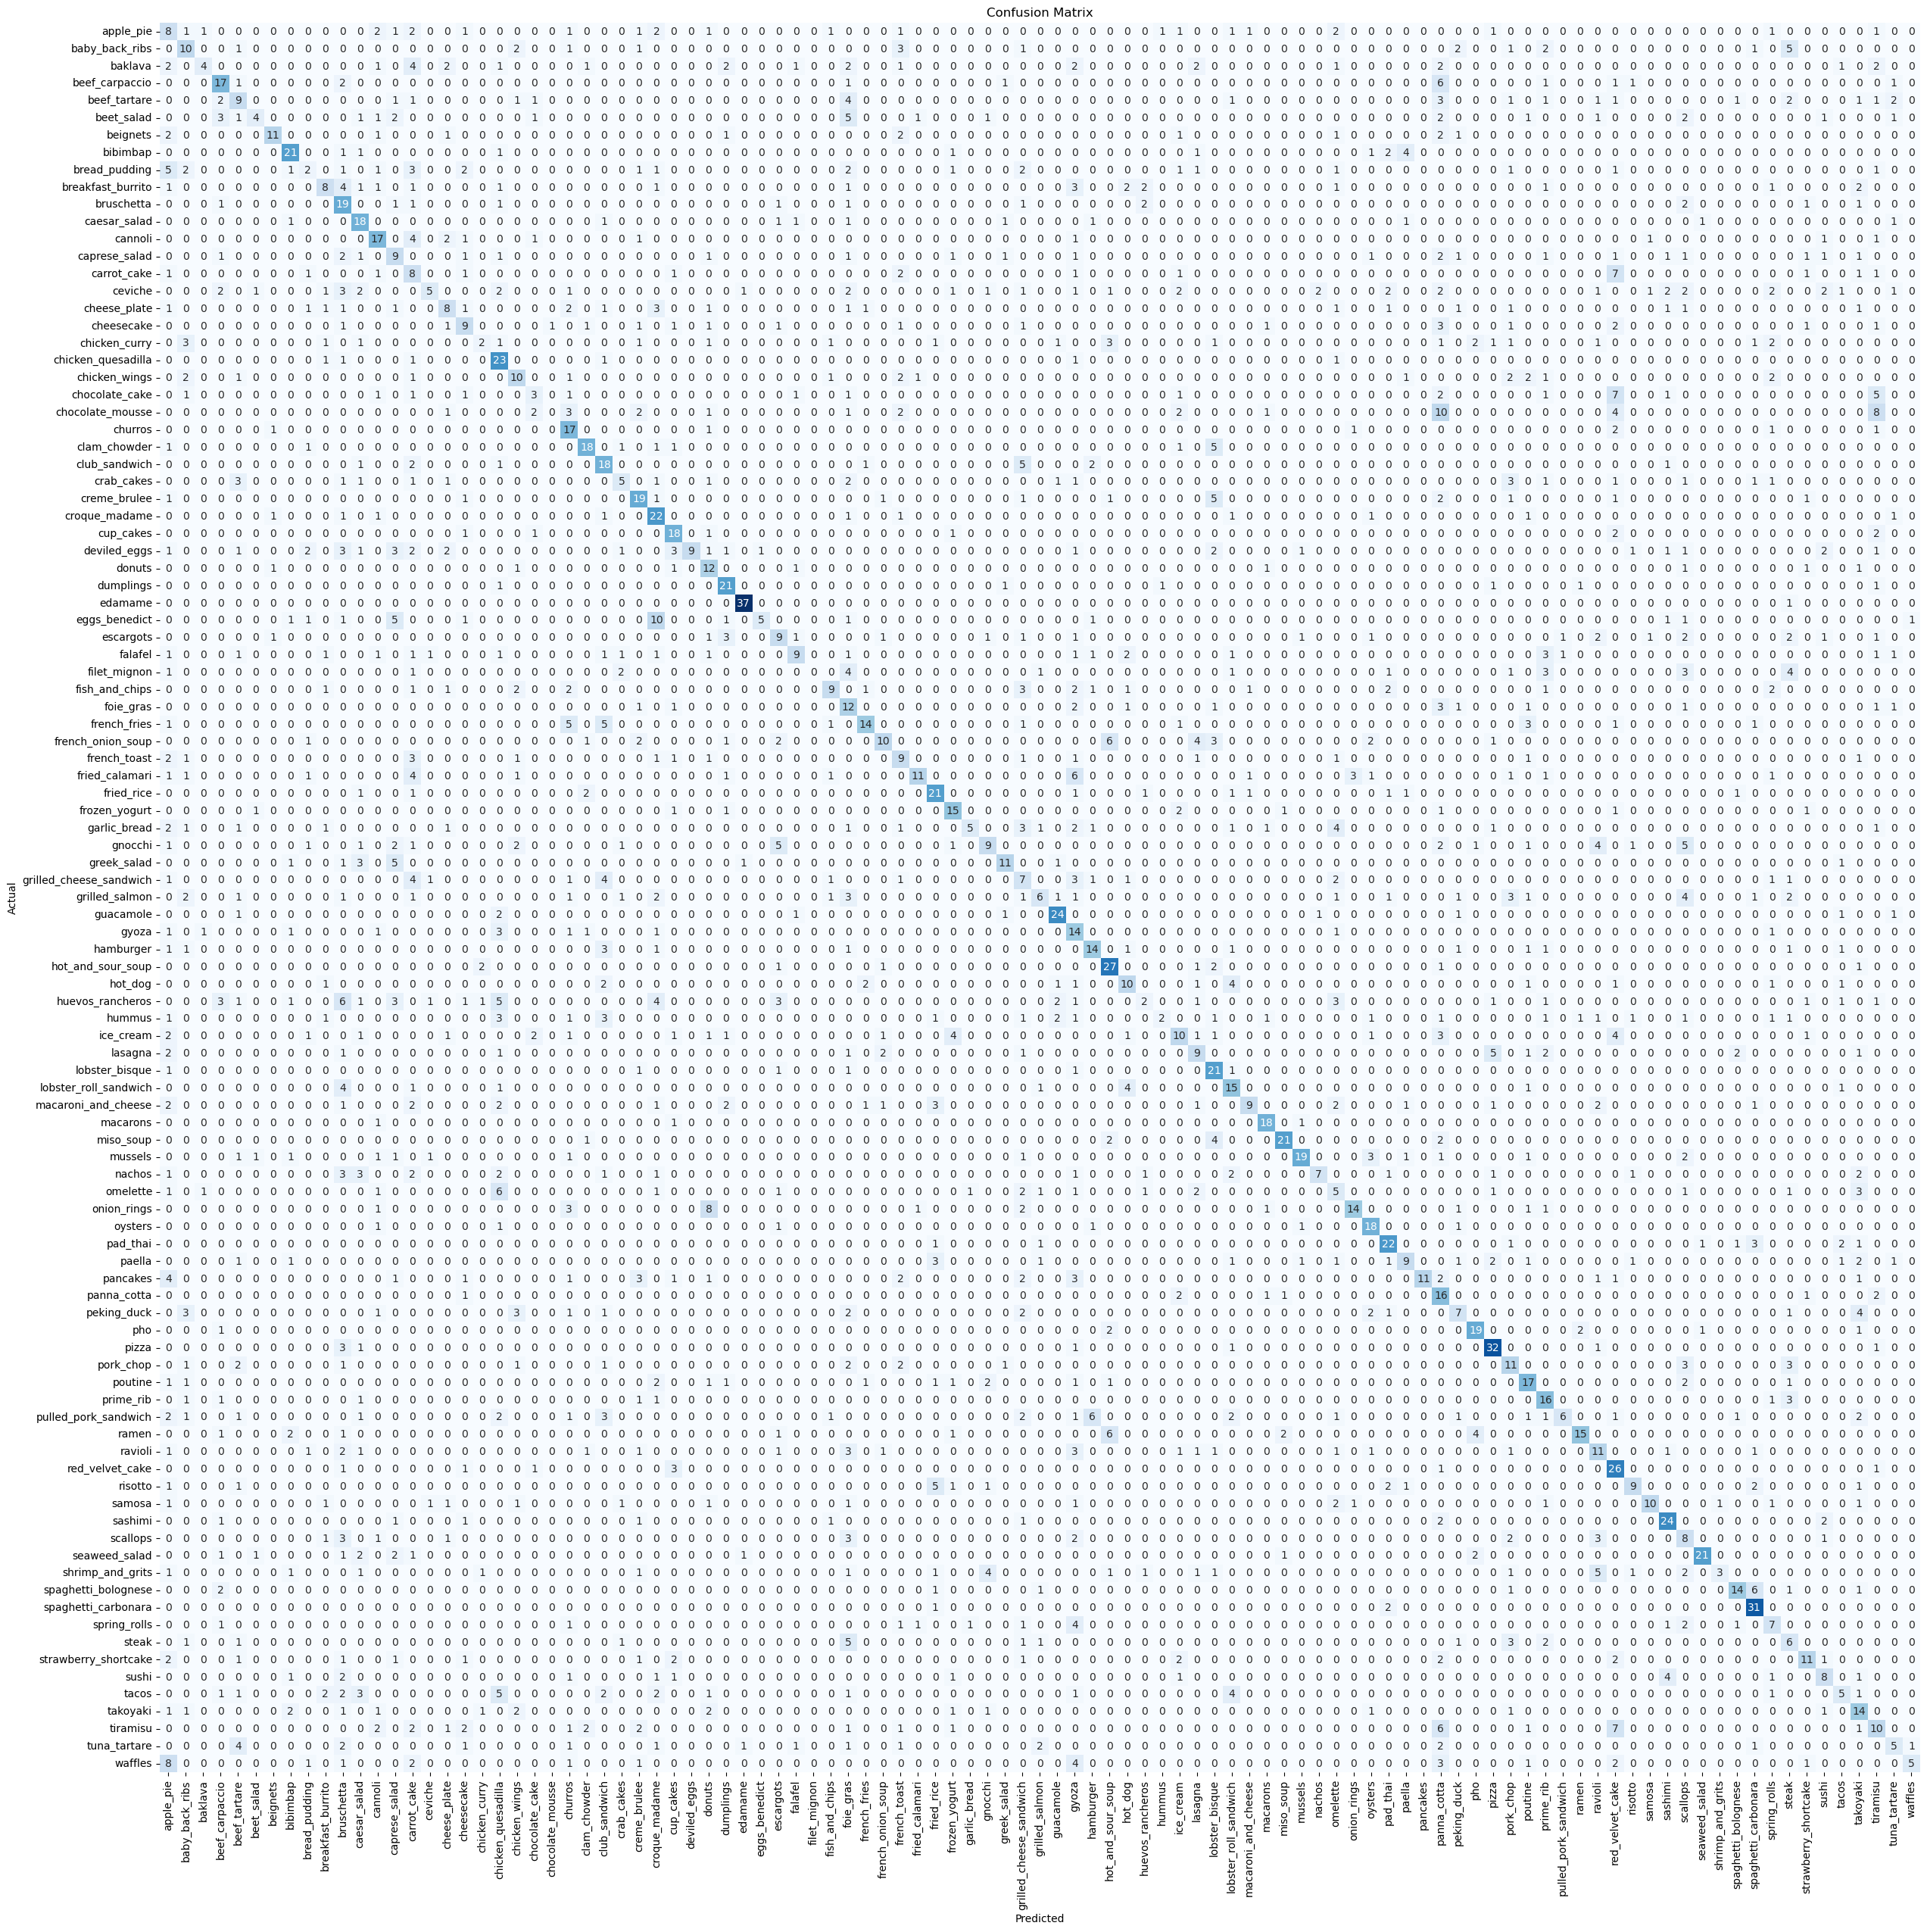

In [16]:
plt.figure(figsize=(30, 30))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=np.arange(101) + 0.5, labels=test_images.class_indices, rotation=90)
plt.yticks(ticks=np.arange(101) + 0.5, labels=test_images.class_indices, rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()